In [1]:
import sys
sys.path.append('/home/linxuangao')  # 确保父目录在 Python 路径中

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import torch
import umap
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from GPNSF.model import GPNSFModel
from GPNSF.utils import *


import warnings
warnings.filterwarnings("ignore")

/home/linxuangao/.conda/envs/glx/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 指定GPU设备索引
gpu_id = 2  # 使用第4张GPU（索引从0开始）
torch.cuda.set_device(gpu_id)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

print(f'Using device: {device}')
print(f'Current GPU: {torch.cuda.current_device()}')

Using device: cuda
Current GPU: 2


In [4]:
data_dir = '/home/linxuangao/data_gpnsf/Dataset13_Simulation1'
adata1 = sc.read_h5ad(f'{data_dir}/adata_RNA.h5ad')
X_1 = adata1.layers['counts']
S = adata1.obsm['spatial']
spfac = adata1.obsm['spfac']
nsfac = adata1.obsm['nsfac']
spload_1 = adata1.varm['spload']
p = X_1.shape[1]
adata2 = sc.read_h5ad(f'{data_dir}/adata_ADT.h5ad')
X_2 = adata2.layers['counts']
spload_2 = adata2.varm['spload']
q = X_2.shape[1]

In [5]:
# 重新加载 GPNSF 并将 numpy/sparse 转为 torch 张量
from importlib import reload
import GPNSF.model as gp_model
reload(gp_model)
from GPNSF.model import GPNSFModel

import numpy as np
import scipy.sparse as sp

def to_torch_tensor(x, device, dtype=torch.float32):
    if hasattr(x, "toarray"):
        x = x.toarray()  # scipy.sparse -> ndarray
    if isinstance(x, np.ndarray):
        return torch.as_tensor(x, dtype=dtype, device=device)
    if isinstance(x, torch.Tensor):
        return x.to(device=device, dtype=dtype)
    raise TypeError(f"Unsupported type: {type(x)}")

S_t = to_torch_tensor(S, device, dtype=torch.float32)
X1_t = to_torch_tensor(X_1, device, dtype=torch.float32)
X2_t = to_torch_tensor(X_2, device, dtype=torch.float32)

print('Converted ->', 'S:', S_t.shape, 'X1:', X1_t.shape, 'X2:', X2_t.shape, 'device=', device)

Converted -> S: torch.Size([1296, 2]) X1: torch.Size([1296, 1000]) X2: torch.Size([1296, 100]) device= cuda


In [24]:
K = 4
M = 40

In [25]:
from tqdm import tqdm
# 构建模型与训练循环（周期性打印 loss/ELBO/KL）
model = GPNSFModel(S=S_t, p=p, q=q, K=K, M=M, eta=10.0, num_mc_samples=3, likelihood_x2='nb', 
                   omega_type='chol', kernel_type='matern32').to(device)

# 修改1: 初始学习率设为1e-3
opt = torch.optim.Adam(model.parameters(), lr=1e-2)  # 原为 lr=5e-4

@torch.no_grad()
def compute_loglik_terms(model, X1, X2):
    # 与模型内部保持一致的 Monte Carlo 估计，并适配 X2 的两种似然模式
    W1, W2 = model.get_W1_W2()
    theta1 = model.theta1
    Hs = model.sample_H()  # (S, n, K)
    loglik1 = []
    loglik2 = []
    if model.likelihood_x2 == 'nb':
        lambda2_nb = model.lambda2_nb
    else:
        lambda2_ber = model.lambda2_ber
        X2_bin = (X2 > 0).to(X2.dtype)
    for t in range(Hs.size(0)):
        H = Hs[t]
        Y1 = torch.exp(H) @ W1
        Y2 = torch.exp(H) @ W2
        loglik1.append(nb_log_prob(X1, Y1, theta1).sum())
        if model.likelihood_x2 == 'nb':
            loglik2.append(nb_log_prob(X2, Y2, lambda2_nb).sum())
        else:
            p2 = torch.clamp(Y2 * lambda2_ber, min=1e-8, max=1.0 - 1e-8)
            loglik2.append(bernoulli_log_prob(X2_bin, p2).sum())
    loglik1 = torch.stack(loglik1).mean()
    loglik2 = torch.stack(loglik2).mean()
    return loglik1, loglik2

num_steps = 5000
print_every = 250

# 修改2: 计算切换学习率的步数
switch_step = int(num_steps * 0.4)  # 前40%步数后切换

for step in tqdm(range(1, num_steps + 1), total=num_steps):
    opt.zero_grad()
    loss = model(X1_t, X2_t)  # 负ELBO
    loss.backward()
    opt.step()

    # 修改3: 在达到切换步数时降低学习率
    if step == switch_step:
        for param_group in opt.param_groups:
            param_group['lr'] = 5e-4
        print(f"\n[step {step:03d}] Learning rate changed to 5e-4")

    if step == 1 or step % print_every == 0:
        with torch.no_grad():
            elbo_val = model.elbo(X1_t, X2_t)
            kl_val = model.compute_KL_u()
            loglik1, loglik2 = compute_loglik_terms(model, X1_t, X2_t)
            current_lr = opt.param_groups[0]['lr']  # 添加显示当前学习率
            print(f"[step {step:03d}] loss={loss.item():.3f}  ELBO={elbo_val.item():.3f}  "
                  f"KL={kl_val.item():.3f}  loglik1={loglik1.item():.3f}  "
                  f"loglik2={loglik2.item():.3f}  lr={current_lr:.1e}")  # 添加学习率显示

print('Training finished.')

  0%|          | 5/5000 [00:00<03:35, 23.13it/s]

[step 001] loss=2833278.250  ELBO=-2807190.750  KL=39.366  loglik1=-2375837.000  loglik2=-436689.812  lr=1.0e-02


  5%|▌         | 255/5000 [00:10<03:13, 24.52it/s]

[step 250] loss=2012206.250  ELBO=-2010141.750  KL=121.870  loglik1=-1684013.750  loglik2=-325937.969  lr=1.0e-02


 10%|█         | 503/5000 [00:20<02:42, 27.67it/s]

[step 500] loss=1953265.500  ELBO=-1953155.000  KL=208.550  loglik1=-1637071.000  loglik2=-313621.469  lr=1.0e-02


 15%|█▌        | 752/5000 [00:30<04:31, 15.63it/s]

[step 750] loss=1942886.625  ELBO=-1942991.000  KL=238.959  loglik1=-1630427.750  loglik2=-310075.406  lr=1.0e-02


 20%|██        | 1006/5000 [00:41<02:21, 28.16it/s]

[step 1000] loss=1940847.250  ELBO=-1940850.250  KL=253.544  loglik1=-1628649.750  loglik2=-309412.375  lr=1.0e-02


 25%|██▌       | 1253/5000 [00:51<02:30, 24.82it/s]

[step 1250] loss=1940473.875  ELBO=-1940321.375  KL=257.692  loglik1=-1628751.500  loglik2=-309396.250  lr=1.0e-02


 30%|███       | 1503/5000 [01:02<02:17, 25.45it/s]

[step 1500] loss=1940549.875  ELBO=-1940090.750  KL=258.692  loglik1=-1628563.750  loglik2=-309021.375  lr=1.0e-02


 35%|███▌      | 1755/5000 [01:11<01:59, 27.06it/s]

[step 1750] loss=1940338.500  ELBO=-1940115.000  KL=258.217  loglik1=-1628197.250  loglik2=-308634.844  lr=1.0e-02


 40%|████      | 2005/5000 [01:21<01:46, 28.07it/s]


[step 2000] Learning rate changed to 5e-4
[step 2000] loss=1939528.375  ELBO=-1940090.500  KL=258.305  loglik1=-1628654.375  loglik2=-308675.000  lr=5.0e-04


 45%|████▌     | 2255/5000 [01:31<01:41, 26.91it/s]

[step 2250] loss=1939743.625  ELBO=-1940117.875  KL=257.486  loglik1=-1628535.375  loglik2=-308592.875  lr=5.0e-04


 50%|█████     | 2503/5000 [01:42<02:37, 15.88it/s]

[step 2500] loss=1939738.500  ELBO=-1939740.375  KL=257.525  loglik1=-1628681.375  loglik2=-308667.688  lr=5.0e-04


 55%|█████▌    | 2755/5000 [01:52<01:28, 25.24it/s]

[step 2750] loss=1940132.000  ELBO=-1939644.500  KL=257.473  loglik1=-1628466.000  loglik2=-308561.438  lr=5.0e-04


 60%|██████    | 3004/5000 [02:02<01:20, 24.81it/s]

[step 3000] loss=1939632.000  ELBO=-1939534.250  KL=257.275  loglik1=-1628826.750  loglik2=-308488.562  lr=5.0e-04


 65%|██████▌   | 3253/5000 [02:12<01:23, 20.95it/s]

[step 3250] loss=1939616.500  ELBO=-1939793.750  KL=257.570  loglik1=-1628485.500  loglik2=-308578.938  lr=5.0e-04


 70%|███████   | 3503/5000 [02:22<01:00, 24.60it/s]

[step 3500] loss=1939701.000  ELBO=-1939524.000  KL=257.371  loglik1=-1628677.250  loglik2=-308515.875  lr=5.0e-04


 75%|███████▌  | 3753/5000 [02:32<00:47, 26.42it/s]

[step 3750] loss=1939754.000  ELBO=-1939482.125  KL=257.192  loglik1=-1628545.375  loglik2=-308395.469  lr=5.0e-04


 80%|████████  | 4003/5000 [02:42<00:40, 24.45it/s]

[step 4000] loss=1939745.750  ELBO=-1939241.250  KL=257.229  loglik1=-1628531.500  loglik2=-308433.875  lr=5.0e-04


 85%|████████▌ | 4254/5000 [02:51<00:37, 19.84it/s]

[step 4250] loss=1939948.500  ELBO=-1939707.250  KL=257.019  loglik1=-1628809.250  loglik2=-308478.719  lr=5.0e-04


 90%|█████████ | 4504/5000 [03:01<00:20, 24.13it/s]

[step 4500] loss=1939438.375  ELBO=-1939852.375  KL=257.117  loglik1=-1628704.875  loglik2=-308465.812  lr=5.0e-04


 95%|█████████▌| 4753/5000 [03:11<00:09, 26.56it/s]

[step 4750] loss=1939763.500  ELBO=-1939793.250  KL=257.004  loglik1=-1628445.000  loglik2=-308260.969  lr=5.0e-04


100%|██████████| 5000/5000 [03:22<00:00, 24.75it/s]

[step 5000] loss=1940052.250  ELBO=-1939246.375  KL=256.861  loglik1=-1628638.875  loglik2=-308400.750  lr=5.0e-04
Training finished.


# 可视化 K 个空间分量（基于 q(H) 的均值）

下面两格：
- 先从模型的变分边缘 q(H) 提取每个因子在所有点的均值（并给出 exp(H) 版本）。
- 再在坐标 S 上绘制 K 个分量的热力图（支持 scatter/heatmap/combined）。

In [26]:
# 计算 q(H) 的均值并导出两种可视化矩阵：H_mu, H_exp
import numpy as np
import torch

with torch.no_grad():
    n = S_t.size(0)
    K_model = model.K
    H_mu = torch.empty(n, K_model, device=S_t.device, dtype=S_t.dtype)
    for k_idx in range(K_model):
        mu_k, _ = model.q_h_params(k_idx)  # (n,), (n,)
        H_mu[:, k_idx] = mu_k
    H_exp = torch.exp(H_mu)
    

print('H_mu/H_exp shapes ->', H_mu.shape, H_exp.shape)

# 转为 numpy，便于绘图
S_np = S_t.detach().cpu().numpy()
H_mu_np = H_mu.detach().cpu().numpy()
H_exp_np = H_exp.detach().cpu().numpy()

H_mu/H_exp shapes -> torch.Size([1296, 4]) torch.Size([1296, 4])


In [27]:
# 先删除所有以'Factor_'开头的列
factor_cols = [col for col in adata1.obs.columns if col.startswith('Factor_')]
adata1.obs = adata1.obs.drop(columns=factor_cols)


# row_norms = np.linalg.norm(H_exp_np, axis=1, keepdims=True)
# H_exp_np_normalized = H_exp_np / row_norms

row_sums = H_exp_np.sum(axis=0, keepdims=True)
H_exp_np_normalized = H_exp_np / row_sums


# row_sums = H_exp_np.sum(axis=1, keepdims=True)
# row_means = row_sums / H_exp_np.shape[1]
# threshold = 1 * row_means
# H_exp_np_filtered = np.where(H_exp_np < threshold, 0, H_exp_np)
# row_sums_filtered = H_exp_np_filtered.sum(axis=1, keepdims=True)
# H_exp_np_normalized = H_exp_np_filtered / row_sums_filtered


temp = pd.DataFrame(H_exp_np_normalized, columns=[f'Factor_{k+1}' for k in range(H_exp_np_normalized.shape[1])])
temp.index = adata1.obs.index
adata1.obs = adata1.obs.join(temp)

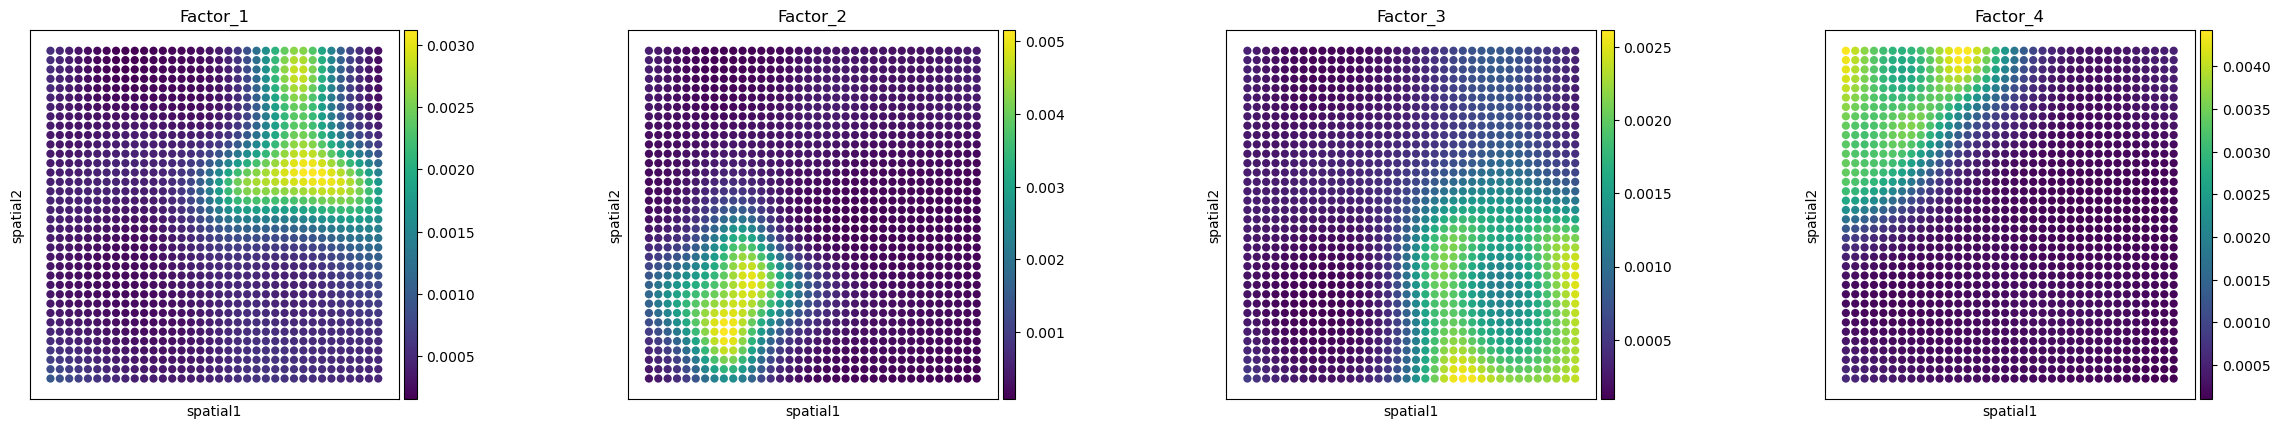

In [28]:
# 创建图形并保存
fig = sc.pl.spatial(
    adata=adata1,
    color=[f'Factor_{k+1}' for k in range(H_exp_np_normalized.shape[1])],
    spot_size=0.1,
    show=True  # 关键：不显示，只返回图形对象
)

# # 保存图片
# plt.savefig('sim_648_spatial_factors.png', 
#             dpi=300, 
#             bbox_inches='tight',  # 紧凑布局
#             facecolor='white')    # 背景色
# plt.close()  # 关闭图形，释放内存

In [51]:
# for i in range(adata1.obsm['spfac'].shape[1]):
#     adata1.obs[f'factor {i+1}'] = adata1.obsm['spfac'][:, i]

# sc.pl.spatial(adata1, color=[f'factor {i+1}' for i in range(adata1.obsm['spfac'].shape[1])], spot_size=0.1, save='sim_gt_spatial_factors')

In [52]:
# for i in range(adata1.obsm['nsfac'].shape[1]):
#     adata1.obs[f'factor {i+1}'] = adata1.obsm['nsfac'][:, i]

# sc.pl.spatial(adata1, color=[f'factor {i+1}' for i in range(adata1.obsm['nsfac'].shape[1])], spot_size=0.1, save='sim_gt_ns_factors')